# System building

## Import modules

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import model_openface as mo ## custom helper module
import cv2 ## openCV
import os
import numpy as np
import matplotlib.pyplot as plt
import operator
import pickle
%matplotlib inline
%precision 2
original_path = os.getcwd()

Using TensorFlow backend.


## Construct a predefined model/weights for face recognition ([OpenFace](https://github.com/iwantooxxoox/Keras-OpenFace))

In [2]:
model = mo.model_openface()
mo.load_weight_openface(model)

## parameters

In [3]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
## for input images
img_width = 550
img_height = 750
## for cropped face
img_col = 96
img_row = 96

box_size_factor = 10 # bigger value allows smaller bounding box
face_recog_thresh = 0.70

## helper functions
### `embed_image` to embed processed face images into 128d vectors

In [4]:
def embed_image(face_img,model):
    '''
    embed the RGB cropped face (input) into 128d vector
    use with `detect_face()`
    '''
    img = cv2.resize(face_img, (img_col,img_row)).astype('float32')
    img /= 255.0
    img = np.expand_dims(img,axis=0)
    embedding = model.predict_on_batch(img)
    return embedding

### `detect_face` to detect frontal faces in *gray* (higher accuracy than doing it in color) 

In [5]:
def detect_face(img,fc=face_cascade,flag='db',plot=False):
    '''
    Receive BGR format as an input and return coordinate(s) of detected face(s)
    
    default: flag = 'db' --> assume only one face is present in the image and return only 1 face
    flag = 'new' --> if to embed new images (possibly multiple faces)
    '''
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    height,width = img_grey.shape
    faces_raw = fc.detectMultiScale(img_grey) # higher accuracy for faces with black glasses
    faces = []
    
    # get rid of errorneous small boxes
    for face in faces_raw:
        if face[2] > (min(height,width)/box_size_factor):
            faces.append(face)
            
    if flag == 'db':
        face_box = [0,0,0,0]
        for (x,y,w,h) in faces:
            if w > face_box[2]:
                face_box = [x,y,w,h] # IGNOTE ALL OTHER FALSY FACE BOXES for database embedding
        (x,y,w,h) = face_box
        faces = [face_box]       
    if flag == 'new':
        faces = faces
        
    if plot:
        num_col = 5
        img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_color_for_crop = img_color.copy()
        for (plot_x,plot_y,plot_w,plot_h) in faces:   
            img_color = cv2.rectangle(img_color, (plot_x,plot_y), (plot_x+plot_w,plot_y+plot_h), (255,0,0), 8)

        plt.title('full image',fontdict={'fontsize':15,'fontweight':'bold'})
        plt.imshow(img_color)
        plt.axis('off')
        if len(faces) == 1:
            (plot_x,plot_y,plot_w,plot_h) = faces[0]
            fig,ax=plt.subplots(1,1,figsize=(3,3))
            cropped = img_color_for_crop[plot_y:plot_y+plot_h,plot_x:plot_x+plot_w]
            ax.imshow(cropped)
            ax.axis('off')
            fig.suptitle('Cropped face image to be embedded',fontsize=15,fontweight='bold')  
        elif len(faces)<=num_col:
            fig,axes=plt.subplots(1,len(faces),figsize=(3*len(faces),3))
            for ax,(plot_x,plot_y,plot_w,plot_h) in zip(axes.flatten(),faces):
                cropped = img_color_for_crop[plot_y:plot_y+plot_h,plot_x:plot_x+plot_w]
                ax.imshow(cropped)
                ax.axis('off')
            fig.suptitle('Cropped face image to be embedded (not ordered)',fontsize=15,fontweight='bold')
        else:
            fig, axes = plt.subplots(int(np.ceil(len(faces)/num_col)),num_col,figsize=(15,3*int(np.ceil(len(faces)/num_col))))
            fig.suptitle('Cropped face image to be embedded (not ordered)',fontsize=15,fontweight='bold')

            for ax,(plot_x,plot_y,plot_w,plot_h) in zip(axes.flatten(),faces):
                cropped = img_color_for_crop[plot_y:plot_y+plot_h,plot_x:plot_x+plot_w]
                ax.imshow(cropped)
                ax.axis('off')
            if not len(faces)==len(axes.flatten()):
                for i in axes.flatten()[len(faces)-len(axes.flatten()):]:
                    i.set_visible(False)
    return faces

### `database_face_embedding` to process and embed images in the database

In [6]:
def database_face_embedding():
    '''
    embed the images in the database
    output = {'name':embedding,...}
    '''
    database_embeddings = {}
    os.chdir(os.path.join(os.getcwd(),'image_database'))
    for img_file in os.listdir():
        name = img_file.split('.')[0]
        image_file = cv2.imread(img_file)
        image_file = cv2.resize(image_file,(img_width,img_height), interpolation = cv2.INTER_AREA)
        faces = detect_face(image_file)
        (x, y, w, h) = faces[0]
        image_file = cv2.cvtColor(image_file, cv2.COLOR_BGR2RGB)
        cropped = image_file[y:y+h,x:x+w]
        database_embeddings[name] = embed_image(cropped, model)
    os.chdir(original_path)
    return database_embeddings

### `identify_singe_face` to identify person given a single face image

In [7]:
def identify_singe_face(new_face,database_embeddings,model,verbose=None): 
    '''
    receive one new RGB face as an input
    return name_label of that face as one of the registered members
    '''    
    new_face_embedding = embed_image(new_face,model)
    name_label = ''
    result = {}
    min_dist = 100
    for (registered_name,registered_embedding) in database_embeddings.items():
        euc_dist = np.linalg.norm(new_face_embedding-registered_embedding)
        result[registered_name] = euc_dist

        if euc_dist < min_dist:
            min_dist = euc_dist
            name = registered_name
    if min_dist < face_recog_thresh:
        if verbose:
            print('***this is {}!***\n'.format(name.upper()))
            print('Distance from:')
            for i in sorted(result.items(),key=operator.itemgetter(1)):
                print(i)
            
        name_label = name
        return name_label
    else:
        name_label = 'n/a'
        return name_label

### `recog_face` to recognize multiple faces in a single frame (image)

In [8]:
def recog_face(img,fc=face_cascade,verbose=None):
    '''
    receive BGR image as an input
    ''' 
    img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    faces = detect_face(img,flag='new')
    names = []
        
    for (x, y, w, h) in faces:
        cropped = img_color[y:y+h,x:x+w]
        if verbose:
            name = identify_singe_face(cropped,database_embeddings,model,verbose=True)
        if not verbose:
            name = identify_singe_face(cropped,database_embeddings,model)
        
        text = '{}'.format(name)
        (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_PLAIN,3,5)[0]
        text_offset_x = x-3
        text_offset_y = y
        box_coords = ((text_offset_x, text_offset_y+10), (text_offset_x+text_width,text_offset_y-text_height-10))
        
        if name != 'n/a':
            img_color = cv2.rectangle(img_color, (x, y), (x+w, y+h), (255,0,0), 8)
            img_color = cv2.rectangle(img_color, box_coords[0], box_coords[1], (255,0,0), cv2.FILLED)
            img_color = cv2.putText(img_color,text,(x,y),cv2.FONT_HERSHEY_PLAIN,3,(255,255,255),4)
            names.append(name)

    plt.figure(figsize=(8,8))
    plt.imshow(img_color)
    plt.axis('off')   

# Testing on images and videos!

## Image testing files

In [9]:
db_img_sean = cv2.imread(os.path.join('image_database','sean.jpg'))
db_img_sean = cv2.resize(db_img_sean, (img_width,img_height), interpolation = cv2.INTER_AREA)

## `detect_face` examples

[[177, 139, 200, 200]]

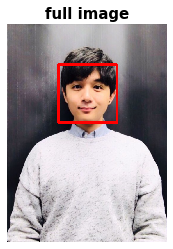

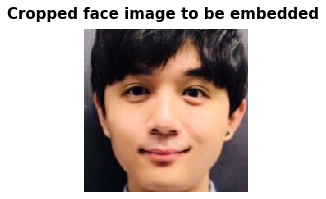

In [10]:
detect_face(db_img_sean,fc=face_cascade,flag='db',plot=True)

In [11]:
# detect_face(test_img_multi,fc=face_cascade,flag='new',plot=True)

NOTE: face detection algorithm was not very accurate in this case above. In order to make sure that the face is correctly detected for database registration:
* the input image needs to contain only a single frontal-looking face
* use `flag='db'` in `detect_face()`

## Database embedding
* If you are using the prepared Insight embeddings, simply load **'insight_embedding.pkl'**.
* If you want to create your own embedding database, CREATE a folder named 'image_database' and place your database images there


In [12]:
database_embeddings = database_face_embedding()
registered_name = list(database_embeddings.keys())
print('Current database contains {} images: \n{}'.format(len(database_embeddings),[key.upper() for key in registered_name]))
## save embeddings
pickle.dump(database_embeddings,open('insight_embedding.pkl','wb'))

Current database contains 14 images: 
['SOPHIE', 'JAD', 'KEN', 'SERGIO', 'ISSAC', 'SARFO', 'LISA', 'MINA', 'DEN', 'AMANDA', 'CHENG', 'SEAN', 'JEFF', 'LIWEI']


In [13]:
## load embeddings
database_embeddings = pickle.load(open('insight_embedding.pkl','rb'))

## Face detection examples with images

For validation, used the identical picture stored in the database --> 0 distance from *Jason* **(model confirmed!)**

For the details of the wrongly-detected blue bounding box, please refer to the description below in this subsection. In short, this problem arose because `recog_face` uses `detect_face(flag='new')`. However, this would not deteriorate the purpose of this application since we are only interested in the red bounding boxes that are recognized as one of the registered members.

***this is SEAN!***

Distance from:
('sean', 0.0)
('den', 0.5516568)
('ken', 0.5526354)
('sophie', 0.5595005)
('mina', 0.60621643)
('cheng', 0.616253)
('issac', 0.6204685)
('amanda', 0.8065358)
('lisa', 0.80937517)
('jeff', 0.81316906)
('sergio', 0.8380713)
('jad', 0.9529374)
('liwei', 0.96596277)
('sarfo', 1.2842067)


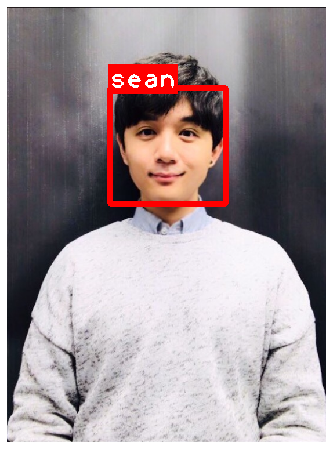

In [14]:
recog_face(db_img_sean,verbose=True)

This image shows the example of many failing points of the current detector.
* my face was not detected possibly due to the sunglasses
* a small part of the face was wrongly detected as a face

These issues were caused by the performance of OpenCV's `face_cascade.detectMultiScale()`. In order to improve the overall detection accuracy, the face detection algorithm can be improved.

A smaller `box_size_factor` value may filter small bounding boxes that are wrongly detected as a face as shown in this image. Or, as we know that those erroneous bounding boxes are recognized as 'n/a' by the face recognizer, the blue bounding boxes (a face of an unregistered person and any false faces) can be removed entirely as they do not convey any meaningful information in the application. 